In [165]:
# ================================
# Import Core libraries
# ================================

# Enables postponed evaluation of type hints (useful for forward references, modern Python practice)
from __future__ import annotations

# anndata is the core data structure used by Scanpy to store single-cell data
import anndata as ad

#for mathematical operations on the large multi dimensional data
import numpy as np

#for efficient 2D tables, data structures   
import pandas as pd

#to create, manipulate, analyze, and visulize complex graphs
import igraph

# Scanpy is the main library for scRNA-seq analysis in Python
import scanpy as sc

# Matplotlib is used for plotting
import matplotlib.pyplot as plt


In [166]:
#Global plotting settings
# Set default figure parameters:
# dpi controls resolution; facecolor ensures white background for publication-quality plots

sc.settings.set_figure_params(dpi=50, facecolor="white")

In [167]:
# ================================
# Load raw 10X Genomics data
# ================================

# sc.read_10x_mtx reads sparse gene-cell matrices produced by 10X Genomics
# - var_names="gene_symbols" uses gene ids for variable names
# - cache=True stores a cached version for faster faster subsequent reading

osteosarcoma = sc.read_10x_mtx("C:/Users/Acer/Desktop/Veena_Patil_Lab/scRNAseq_analysis_practise/Data/patient_4",
    var_names="gene_symbols",
    cache=True)

In [168]:
# to see the number of number of barcodes vs genes
osteosarcoma

AnnData object with n_obs × n_vars = 4768 × 33538
    var: 'gene_ids', 'feature_types'

In [169]:
#list of cell barcodes
osteosarcoma.obs_names

Index(['AAACCCAAGCGATGCA-1', 'AAACCCAAGGAGTATT-1', 'AAACCCACACAGCTTA-1',
       'AAACCCACACCGTCTT-1', 'AAACCCATCGTTTACT-1', 'AAACGAAAGCACCGAA-1',
       'AAACGAAAGGCGATAC-1', 'AAACGAAAGTTCCGGC-1', 'AAACGAACATAGTCGT-1',
       'AAACGAACATCGATGT-1',
       ...
       'TTTGGTTGTAGGACCA-1', 'TTTGGTTGTATCTCTT-1', 'TTTGGTTTCTATGTGG-1',
       'TTTGGTTTCTGTCAGA-1', 'TTTGTTGAGGTGGGTT-1', 'TTTGTTGCAAAGCGTG-1',
       'TTTGTTGCAGTTCCAA-1', 'TTTGTTGGTATCTCTT-1', 'TTTGTTGTCACACCCT-1',
       'TTTGTTGTCCCTTGTG-1'],
      dtype='object', length=4768)

In [170]:
#name of genes
osteosarcoma.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

In [171]:
# Make gene names unique and avoid and duplicates
osteosarcoma.var_names_make_unique()

In [172]:
# ================================
# Identify mitochondrial genes
# ================================

# Create a boolean annotation for mitochondrial genes
# Human mitochondrial genes typically start with "MT-"

osteosarcoma.var["mt"] = osteosarcoma.var_names.str.startswith("MT-")


# ================================
# Quality control (QC) metrics
# ================================

# sc.pp.calculate_qc_metrics computes per-cell QC statistics such as:
# - total_counts: total UMIs per cell
# - n_genes_by_counts: number of detected genes
# - pct_counts_mt: % of mitochondrial reads
sc.pp.calculate_qc_metrics(
    osteosarcoma,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True
)


In [173]:
#take a look at metadata
osteosarcoma.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCAAGCGATGCA-1,2398,8005.0,420.0,5.246721
AAACCCAAGGAGTATT-1,5820,30823.0,2070.0,6.715764
AAACCCACACAGCTTA-1,2871,10066.0,537.0,5.334790
AAACCCACACCGTCTT-1,3907,17419.0,1332.0,7.646822
AAACCCATCGTTTACT-1,4207,20322.0,822.0,4.044878
...,...,...,...,...
TTTGTTGCAAAGCGTG-1,2037,9052.0,376.0,4.153778
TTTGTTGCAGTTCCAA-1,1283,3305.0,249.0,7.534039
TTTGTTGGTATCTCTT-1,1458,5677.0,213.0,3.751982
TTTGTTGTCACACCCT-1,2799,9044.0,813.0,8.989386


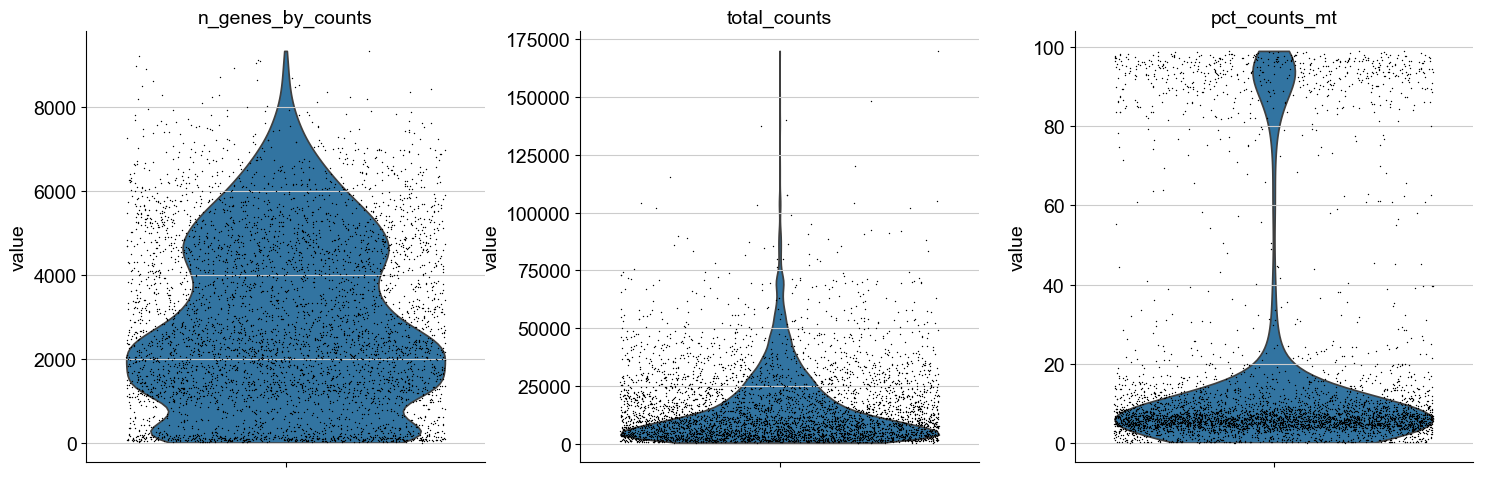

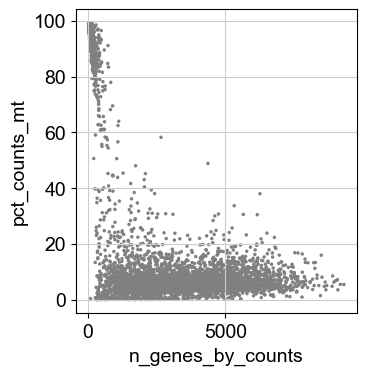

In [174]:
# ================================
# QC visualization
# ================================

# Violin plots to visualize distributions of QC metrics across all cells

sc.pl.violin(
    osteosarcoma,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)
# Scatter plot to inspect relationship between gene complexity and mitochondrial content

sc.pl.scatter(
    osteosarcoma,
    x="n_genes_by_counts",
    y="pct_counts_mt"
)

In [175]:
# ================================
# Cell filtering based on QC
# ================================

# Filter out:
# n_genes_by_counts > 500: Removes empty droplets/low-quality cells
# n_genes_by_counts < 10000: Removes doublets/multiplets
# total_counts < 150000: Removes cells with abnormally high UMI counts
# pct_counts_mt < 25: Removes stressed/dying cells with high mitochondrial content
osteosarcoma = osteosarcoma[
    (osteosarcoma.obs.n_genes_by_counts > 500) &
    (osteosarcoma.obs.n_genes_by_counts < 10000) &
    (osteosarcoma.obs.total_counts < 150000) &
    (osteosarcoma.obs.pct_counts_mt < 25),
    :
]
#check the range to ensure the cell filtering
osteosarcoma.obs["n_genes_by_counts"].min(), osteosarcoma.obs["n_genes_by_counts"].max(), osteosarcoma.obs["total_counts"].min(), osteosarcoma.obs["total_counts"].max(), osteosarcoma.obs["pct_counts_mt"].min(), osteosarcoma.obs["pct_counts_mt"].max()



(np.int64(515),
 np.int64(9192),
 np.float32(799.0),
 np.float32(148460.0),
 np.float32(0.0),
 np.float32(24.991747))

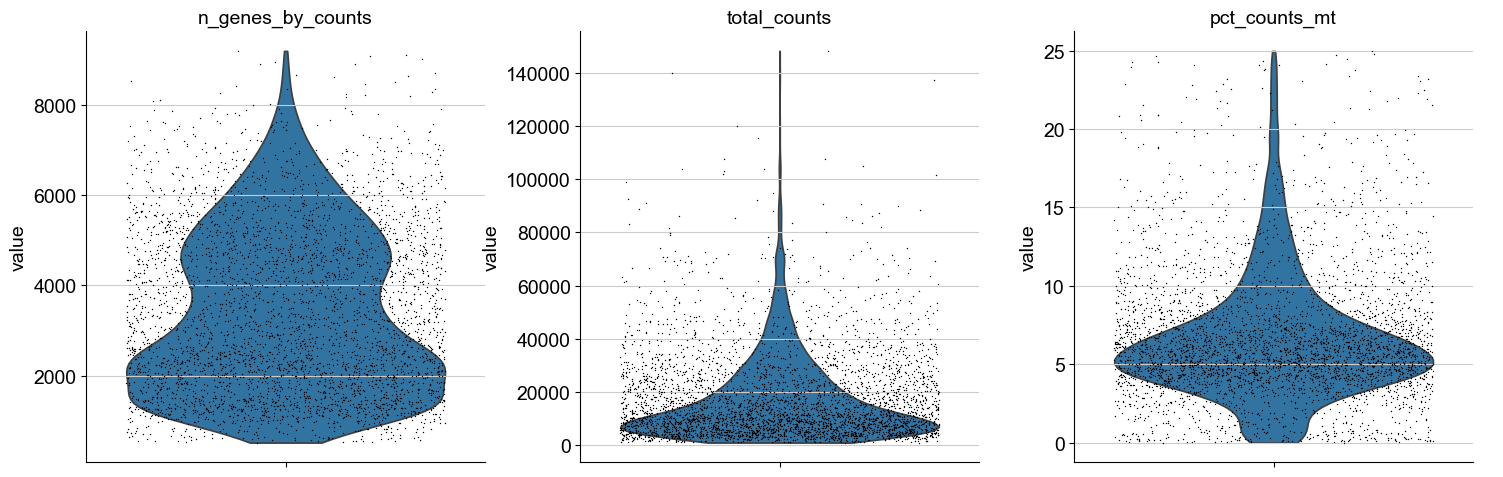

In [176]:
# Violin plots to visualize the change after cell filtering

sc.pl.violin(
    osteosarcoma,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


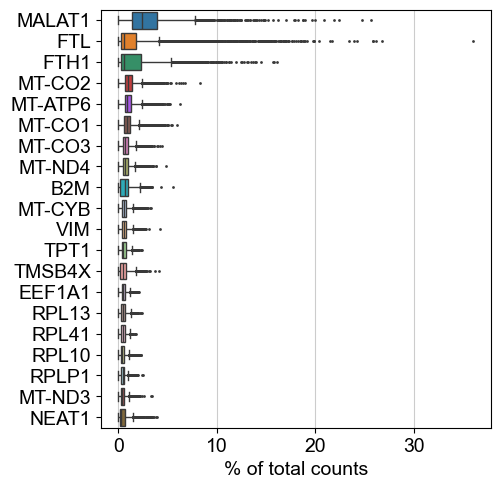

In [177]:
# see the top 20 highly expressed genes
sc.pl.highest_expr_genes(osteosarcoma, n_top=20)

In [178]:
# ================================
# Normalization and log-transformation
# ================================

# Normalize total counts per cell to a fixed value (x to 10000reads per cell)
# This corrects for differences in sequencing depth and counts become comaprable among cells
sc.pp.normalize_total(osteosarcoma, target_sum=1e4)

# Log-transform the normalized data (log(x + 1))
# Stabilizes variance and improves downstream analyses
sc.pp.log1p(osteosarcoma)


c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\legacy_api_wrap\__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


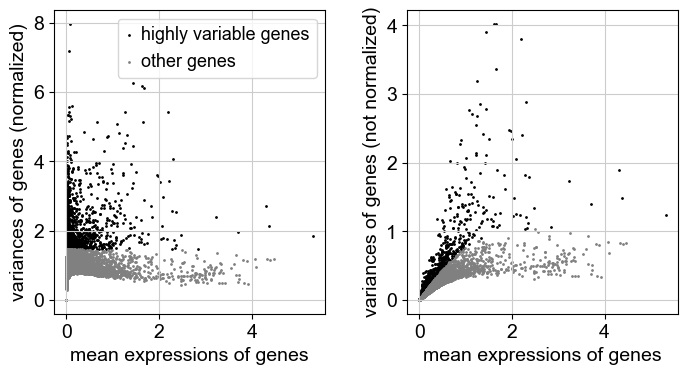

In [179]:
# ================================
# Highly variable gene selection
# ================================

# Identify genes with high biological variability
# - flavor="seurat_v3" uses Seurat v3 variance-stabilization method
# - n_top_genes=2000 selects the top 2000 variable genes
sc.pp.highly_variable_genes(osteosarcoma,
    flavor="seurat_v3",
    n_top_genes=2000
)

# Plot mean–variance relationship of genes
sc.pl.highly_variable_genes(osteosarcoma)


In [180]:
# ================================
# Preserve raw counts
# ================================

# Store raw counts in a separate layer before normalization
# This is important for downstream differential expression
osteosarcoma.layers["counts"] = osteosarcoma.X.copy()

In [181]:
# ================================
# Data scaling
# ================================

# Scale each gene to unit variance and zero mean
# max_value caps extreme values to reduce influence of outliers
#This step centres and scales the gene expression on values and prevents highly expressed genes from dominating PCA

sc.pp.scale(osteosarcoma, max_value=10)


c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_pca\__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


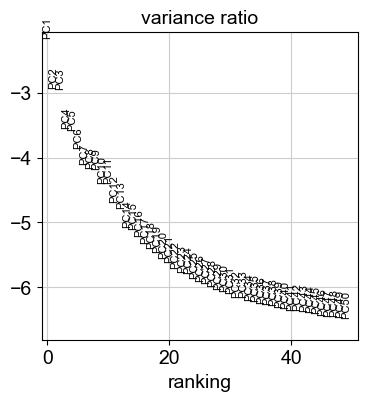

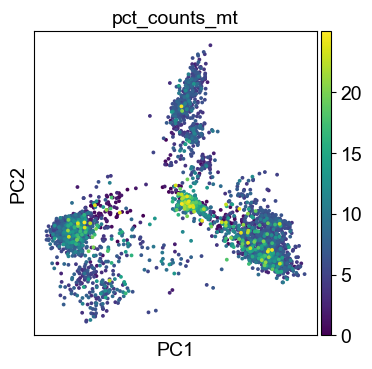

In [182]:
# ================================
# Dimensionality reduction: PCA
# ================================

# Compute principal component analysis, this reduces thousands of genes into PCs for better visualtization
# highly variable genes are are chosen for this while preserving their variance
# n_comps=50 calculates first 50 PCs
sc.tl.pca(
    osteosarcoma,
    n_comps=50,
    use_highly_variable=True
)

# Plot variance explained by each PC (helps decide how many PCs to use further)
sc.pl.pca_variance_ratio(osteosarcoma, n_pcs=50, log=True)

# Visualize cells in PCA space colored by mitochondrial percentage
sc.pl.pca(osteosarcoma, color="pct_counts_mt")


In [183]:
# ================================
# Compute neighborhood graph
# ================================

# Builds a k-nearest neighbor graph using PCA space
# This is required for Leiden, Louvain, and UMAP
sc.pp.neighbors(
    osteosarcoma,
    n_neighbors=30,
    n_pcs=20         
)


In [184]:
# ================================
# Clustering
# ================================

# Perform Leiden clustering:
# - resolution controls cluster granularity
# - igraph backend is fast and widely used
sc.tl.leiden(
  osteosarcoma,
   resolution=0.5,
   flavor="igraph"
)

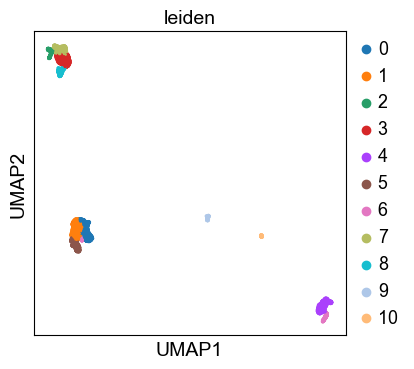

In [185]:
# ================================
# Non-linear dimensionality reduction
# ================================

# Compute UMAP embedding for visualization of clusters 
sc.tl.umap(osteosarcoma)


# Plot UMAP colored by Leiden clusters
sc.pl.umap(osteosarcoma, color="leiden")



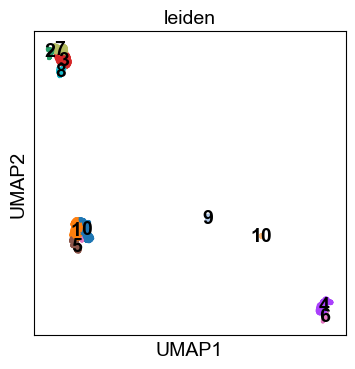

In [186]:
# Overlay cluster labels directly on the UMAP
sc.pl.umap(osteosarcoma, color="leiden", legend_loc="on data")


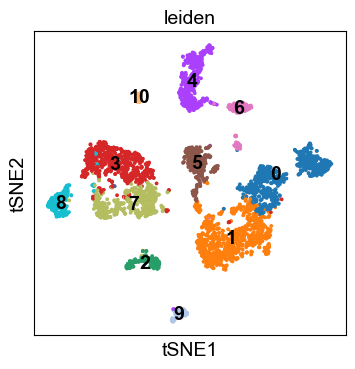

In [187]:
# ================================
# t-SNE visualization
# ================================

# Compute t-SNE using first 20 PCs
sc.tl.tsne(osteosarcoma, n_pcs= 20)

# Plot t-SNE 
sc.pl.tsne(osteosarcoma, color="leiden", legend_loc="on data")


c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid 

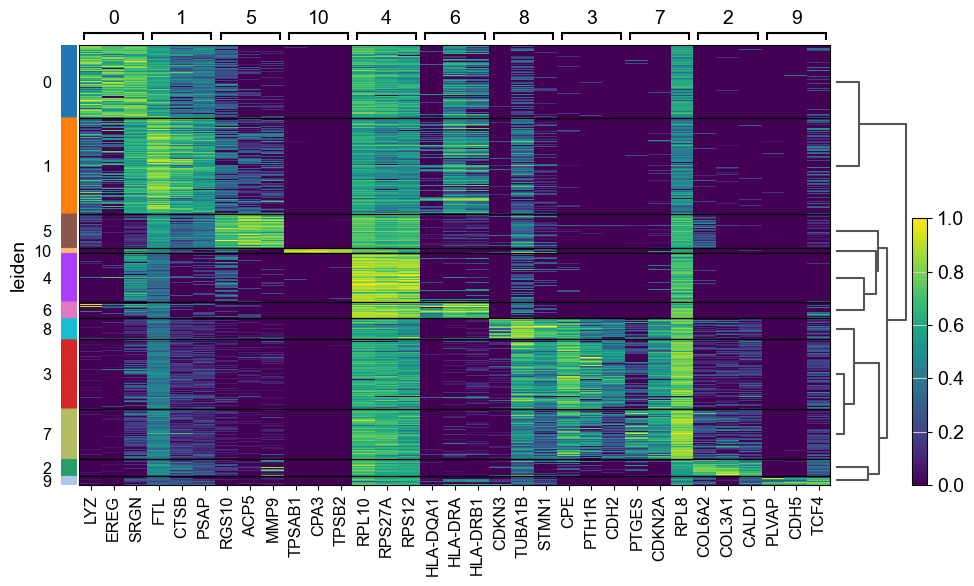

In [188]:
# ================================
# Store raw expression values
# ================================

# Save the log-normalized data as .raw
# This is commonly used for differential expression visualization
osteosarcoma = osteosarcoma


# ================================
# Differential expression analysis
# ================================

# Identify marker genes for each Leiden cluster
# - groupby specifies clustering
# - wilcoxon is a non-parametric test suitable for scRNA-seq data
sc.tl.rank_genes_groups(
    osteosarcoma,
    groupby="leiden",
    method="wilcoxon"
)

# Heatmap of top marker genes per cluster
sc.pl.rank_genes_groups_heatmap(
    osteosarcoma,
    n_genes=3,
    standard_scale="var")

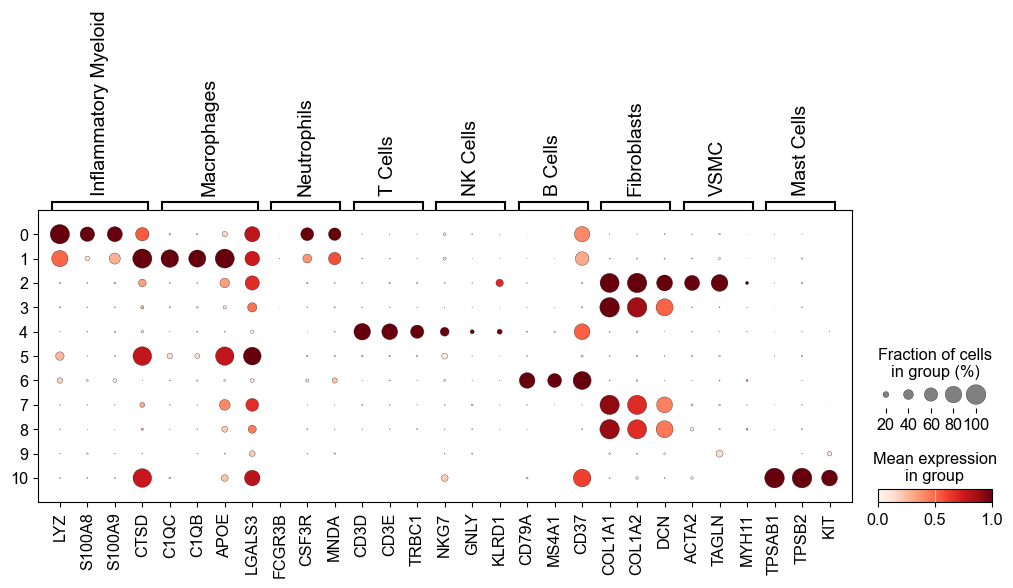

In [189]:
# ================================
# Cell type annotation using canonical markers
# ================================

# this helps us too identify which cell type do each cluster represent, so we can plot them back to the UMAP/tSNE

canonical_markers = {
    "Inflammatory Myeloid": ["LYZ", "S100A8", "S100A9", "CTSD"],
    "Macrophages": ["C1QC", "C1QB", "APOE", "LGALS3"],
    "Neutrophils": ["FCGR3B", "CSF3R", "MNDA"],
    "T Cells": ["CD3D", "CD3E", "TRBC1"],
    "NK Cells": ["NKG7", "GNLY", "KLRD1"],
    "B Cells": ["CD79A", "MS4A1", "CD37"],
    "Fibroblasts": ["COL1A1", "COL1A2", "DCN"],
    "VSMC": ["ACTA2", "TAGLN", "MYH11"],
    "Mast Cells": ["TPSAB1", "TPSB2", "KIT"]
}
# Dot plot showing expression of marker genes across clusters
sc.pl.dotplot(
    osteosarcoma,
    canonical_markers,
    groupby="leiden",
    standard_scale="var"
)


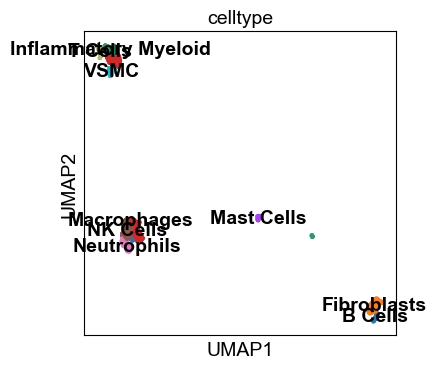

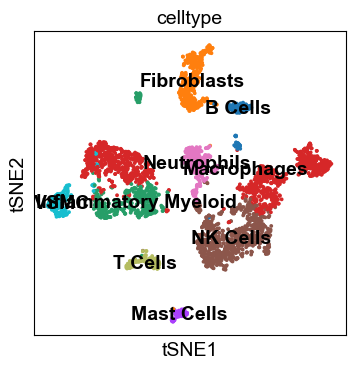

In [190]:
# ================================
# Manual cluster annotation (RenameIdents)
# ================================

#name the clusters to known cell types as confirmed from the dot plot
cluster_map = {
    "0": "Macrophages",
    "1": "NK Cells",
    "2": "T Cells",
    "3": "Macrophages",
    "4": "Fibroblasts",
    "5": "Neutrophils",
    "6": "B Cells",
    "7": "Inflammatory Myeloid",
    "8": "VSMC",
    "9": "Mast Cells",
    "10": "Inflammatory Myeloid",
    "11": "T Cells",
    "12": "Fibroblasts",
    "13": "Macrophages"
}

osteosarcoma.obs["celltype"] = osteosarcoma.obs["leiden"].map(cluster_map)

# plot the UMAP/tSNE plot back with clusters named
sc.pl.umap(osteosarcoma, color="celltype", legend_loc="on data")
sc.pl.tsne(osteosarcoma, color="celltype", legend_loc="on data")

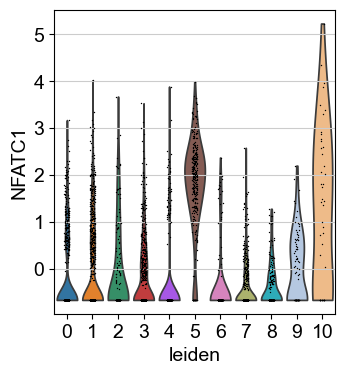

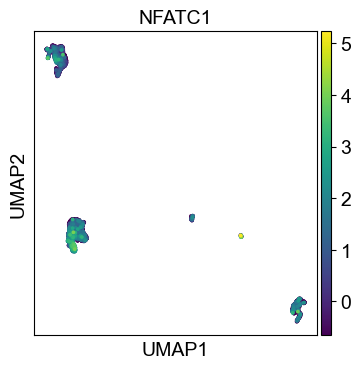

In [191]:
# ================================
# Gene-level visualization
# ================================

# Violin plot of NFATC1 expression across clusters
sc.pl.violin(osteosarcoma,"NFATC1", groupby="leiden",
              stripplot=True)

# NFATC1 expression across cell type clusters shown in the UMAP
sc.pl.umap(osteosarcoma,color="NFATC1")


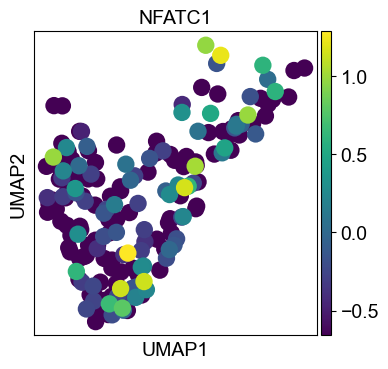

In [192]:
# Visualize NFATC1 expression within the VSMC subset
vsmc = osteosarcoma[osteosarcoma.obs["leiden"].isin(["8"]), :]
sc.pl.umap(vsmc, color="NFATC1")


In [193]:
#save the anndata object 

osteosarcoma.write("osteosarcoma_scRNA_final.h5ad")
